In [31]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc
warnings.filterwarnings('ignore')

#PATH dove andare a leggere e a scrivere
PATH_TO_WRITE_ETL = "./dataset_modificato/"
PATH_FROM_READ_ETL = "./dataset_originale/"
PATH_FROM_READ_ANALYSIS = "./dataset_modificato/" 


sns.set(font_scale=1.8)

In [32]:
df_match_stats = pd.read_csv("./ETL_Mat/stats_match.csv")
#df_team_stats = df_team_stats.drop(['team_name','team_id', 'goals_for','goals_against','world_cup_winner'], axis=1)


#Set the squad you want to know if it's playing in the match
squad_to_classify = "Italy"


team_play_in_the_match = df_match_stats[['match_name','substitutions']]
team_play_in_the_match = team_play_in_the_match.rename(columns={"substitutions": "squad_x_play_in_the_match"})
team_play_in_the_match['squad_x_play_in_the_match'] = 0
team_play_in_the_match.loc[team_play_in_the_match["match_name"].str.contains(squad_to_classify, regex=False), "squad_x_play_in_the_match"] = 1
df_match_stats = df_match_stats.merge(team_play_in_the_match, on="match_name", how="left")
df_match_stats['score'] = df_match_stats['home_team_score'] - df_match_stats['away_team_score']
df_match_stats = df_match_stats.drop(['home_team_name','home_team_id','home_team_code','away_team_name','away_team_id','away_team_code','home_team_score','away_team_score','home_team_score_margin','away_team_score_margin','home_team_score_penalties','away_team_score_penalties','home_team_win','away_team_win'], axis=1)


team_play_in_the_match = df_match_stats['squad_x_play_in_the_match']


In [33]:
df_match_stats.head()

,match_name,score,yellow_card,red_card,substitutions,squad_x_play_in_the_match
0,France v Mexico,3,6,0,5,0
1,France v Mexico,3,6,0,5,0
2,France v Mexico,3,6,0,5,0
3,France v Mexico,3,6,0,5,0
4,Belgium v United States,-3,0,0,0,0


In [34]:
df_match_stats.drop("match_name", axis=1).describe()

,score,yellow_card,red_card,substitutions,squad_x_play_in_the_match
count,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000
mean,0.135754,4.955866,0.355307,6.339106,0.130168
std,1.978647,4.187041,0.682785,4.341949,0.336582
min,-9.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,2.000000,0.000000,4.000000,0.000000
50%,0.000000,4.000000,0.000000,6.000000,0.000000
75%,1.000000,7.000000,1.000000,10.000000,0.000000
max,9.000000,20.000000,4.000000,18.000000,1.000000


In [35]:
# drop useless columns
y=df_match_stats.drop(['match_name','score', 'yellow_card', 'red_card', 'substitutions'], axis=1)
x=df_match_stats.drop(['squad_x_play_in_the_match'], axis=1)
df_match_stats = df_match_stats.drop(['match_name','squad_x_play_in_the_match'], axis=1)
df_match_stats.isnull().sum(axis = 0)

score            0
yellow_card      0
red_card         0
substitutions    0
dtype: int64

In [36]:
# Create dummies - for better model outcomes
df_match_stats = pd.get_dummies(df_match_stats)
df_match_stats.head()

,score,yellow_card,red_card,substitutions
0,3,6,0,5
1,3,6,0,5
2,3,6,0,5
3,3,6,0,5
4,-3,0,0,0


In [37]:
# Data Normalization
names = df_match_stats.columns
scaler = MinMaxScaler()
scaled_d = scaler.fit_transform(df_match_stats[['score','yellow_card','red_card','substitutions']])
df_match_stats[['score','yellow_card','red_card','substitutions']] = scaled_d
x=df_match_stats
df_match_stats.head()

,score,yellow_card,red_card,substitutions
0,0.666667,0.3,0.0,0.277778
1,0.666667,0.3,0.0,0.277778
2,0.666667,0.3,0.0,0.277778
3,0.666667,0.3,0.0,0.277778
4,0.333333,0.0,0.0,0.000000


In [38]:
df_match_stats['squad_x_play_in_the_match'] = pd.Series(team_play_in_the_match)

# Class balance
ld = df_match_stats[df_match_stats.squad_x_play_in_the_match == 1]
no_ld = df_match_stats[df_match_stats.squad_x_play_in_the_match == 0]
print(squad_to_classify + " match played: ", len(ld), squad_to_classify + " match not played: ", len(no_ld))

Italy match played:  233 Italy match not played:  1557


In [39]:
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)


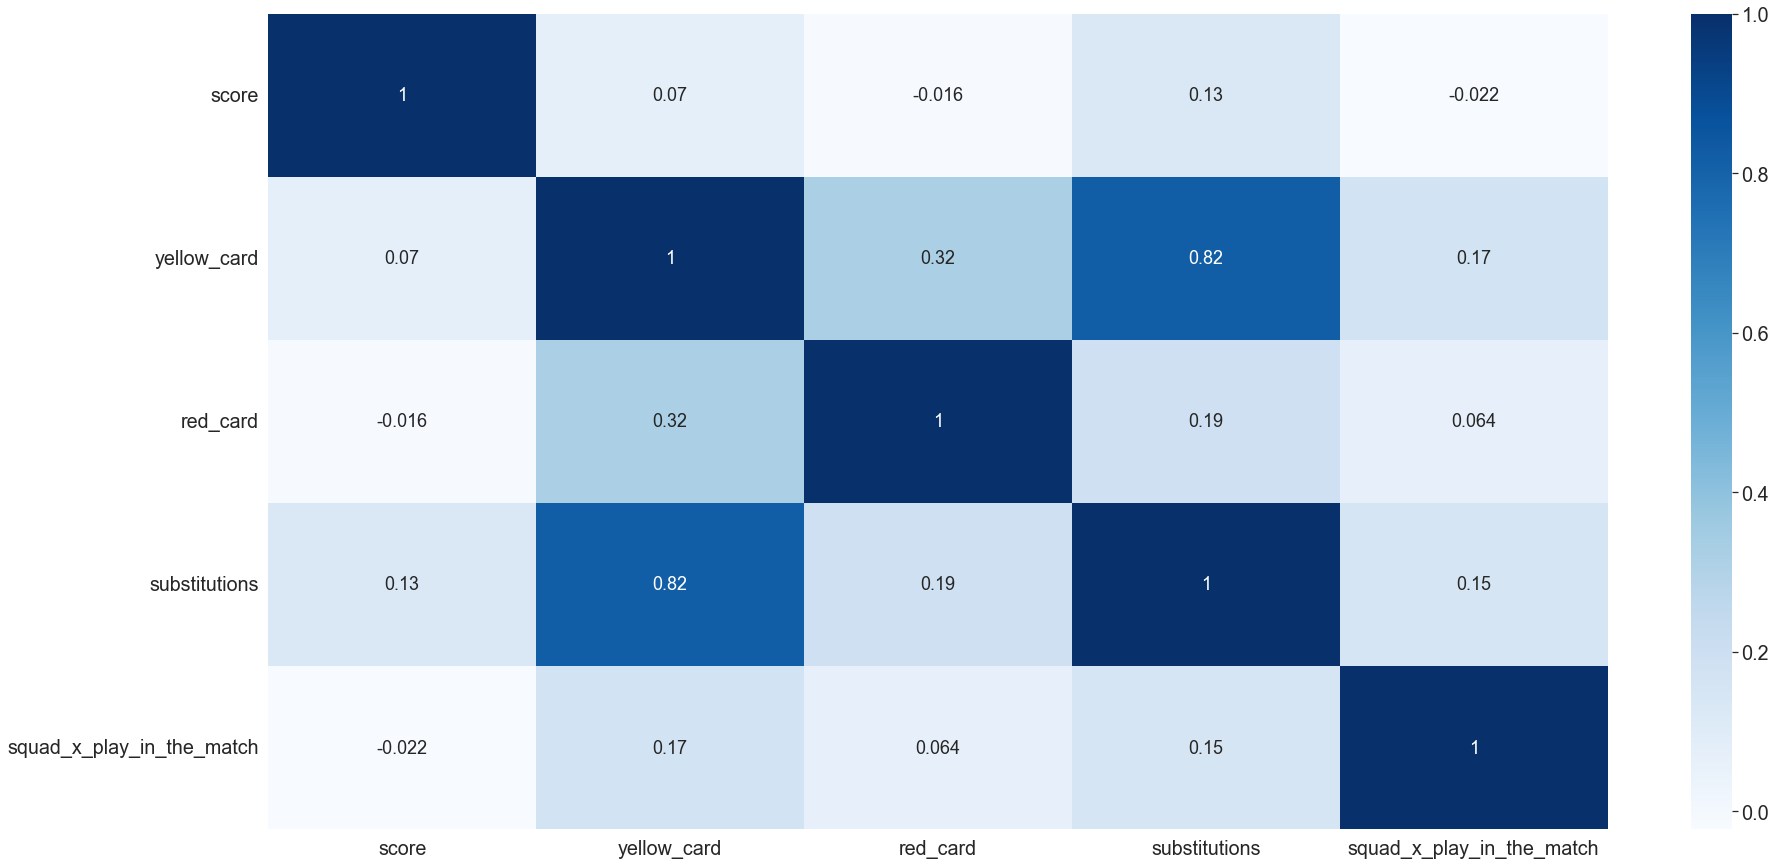

In [41]:
# Check for correlation
#d.corr() #less representative way
plt.figure(figsize=(30,15))
ax = sns.heatmap(df_match_stats[df_match_stats.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [42]:
# Drop values to avoid variables with too high correlation
x = x.drop(['substitutions','squad_x_play_in_the_match'], axis=1)

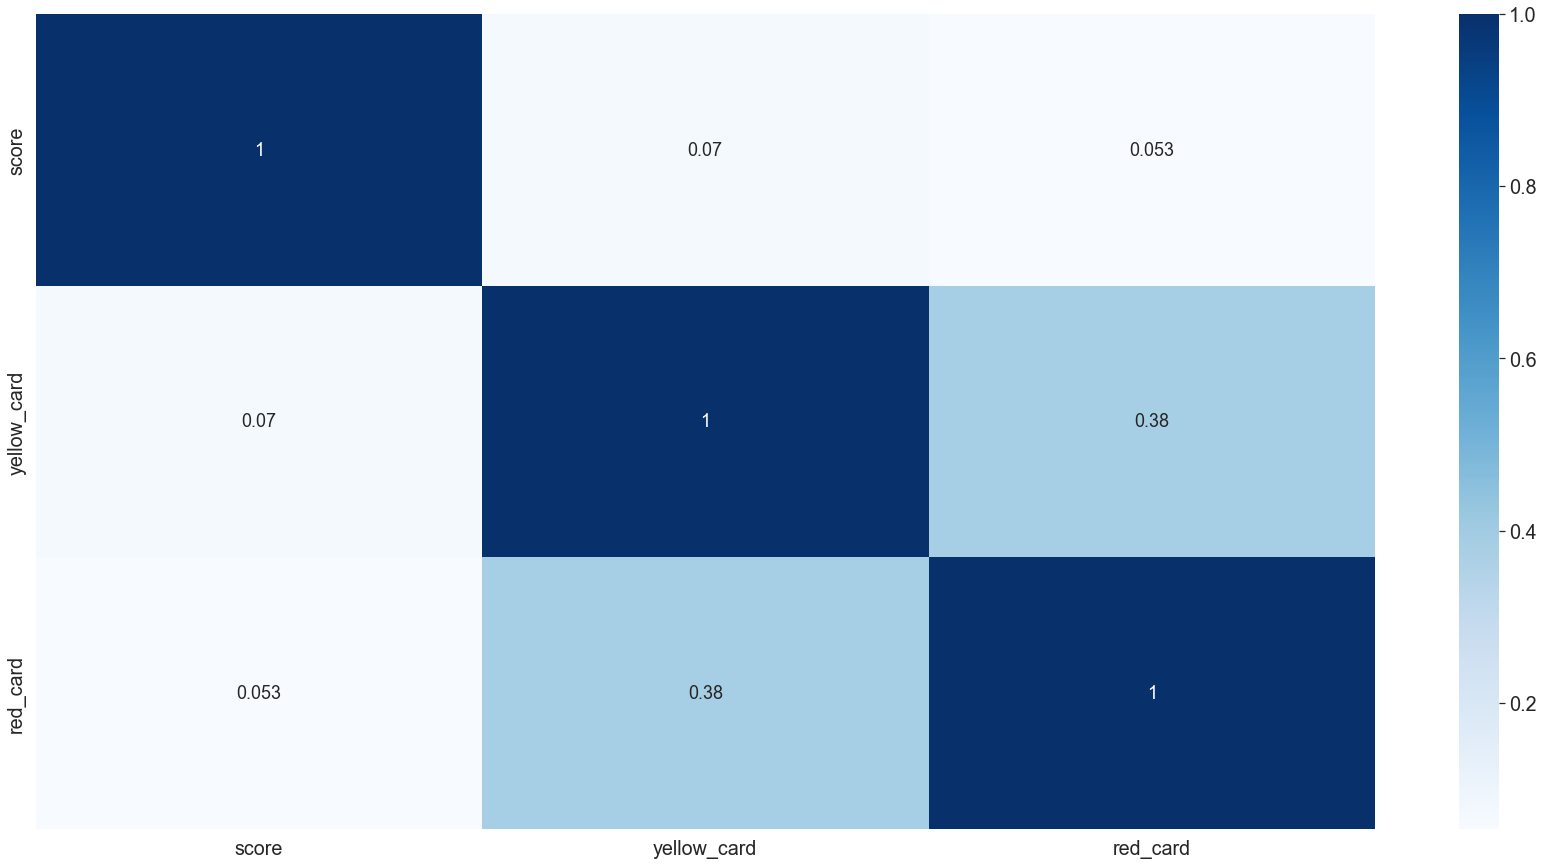

In [43]:
# Check for correlation
#d.corr() #less representative way
plt.figure(figsize=(30,15))
ax = sns.heatmap(x.corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [44]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2491, 3)
(623, 3)
(2491, 1)
(623, 1)


In [45]:
# List of classifiers:
classifiers = [
    DecisionTreeClassifier(random_state=rs),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
    MLPClassifier(random_state=rs),
    GradientBoostingClassifier(random_state=rs),
    LogisticRegression(random_state = rs),
    SVC(probability=True),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    AdaBoostClassifier((DecisionTreeClassifier(random_state=rs)), random_state=rs, learning_rate=0.1),
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [46]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

Accuracy: 0.84 	 ---> DecisionTreeClassifier 
Accuracy: 0.84 	 ---> RandomForestClassifier 
Accuracy: 0.67 	 ---> MLPClassifier 
Accuracy: 0.8 	 ---> GradientBoostingClassifier 
Accuracy: 0.61 	 ---> LogisticRegression 
Accuracy: 0.65 	 ---> SVC 
Accuracy: 0.59 	 ---> GaussianNB 
Accuracy: 0.61 	 ---> LinearDiscriminantAnalysis 
Accuracy: 0.84 	 ---> AdaBoostClassifier 


Text(0.5, 1.0, 'Cross validation scores')

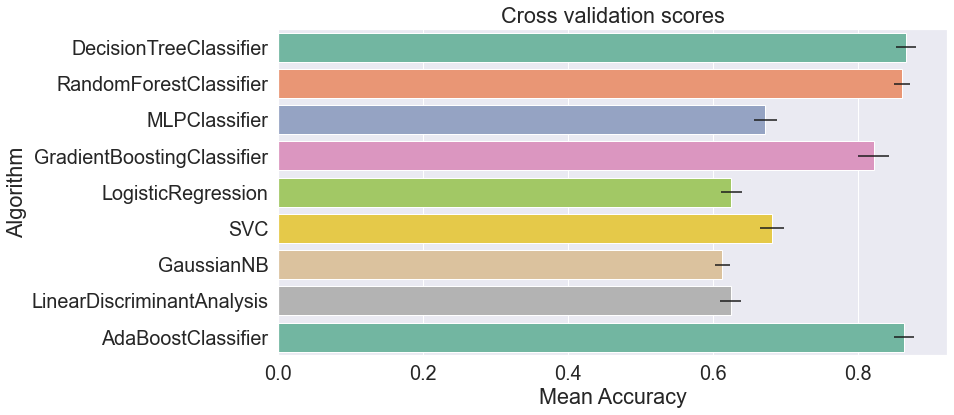

In [47]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

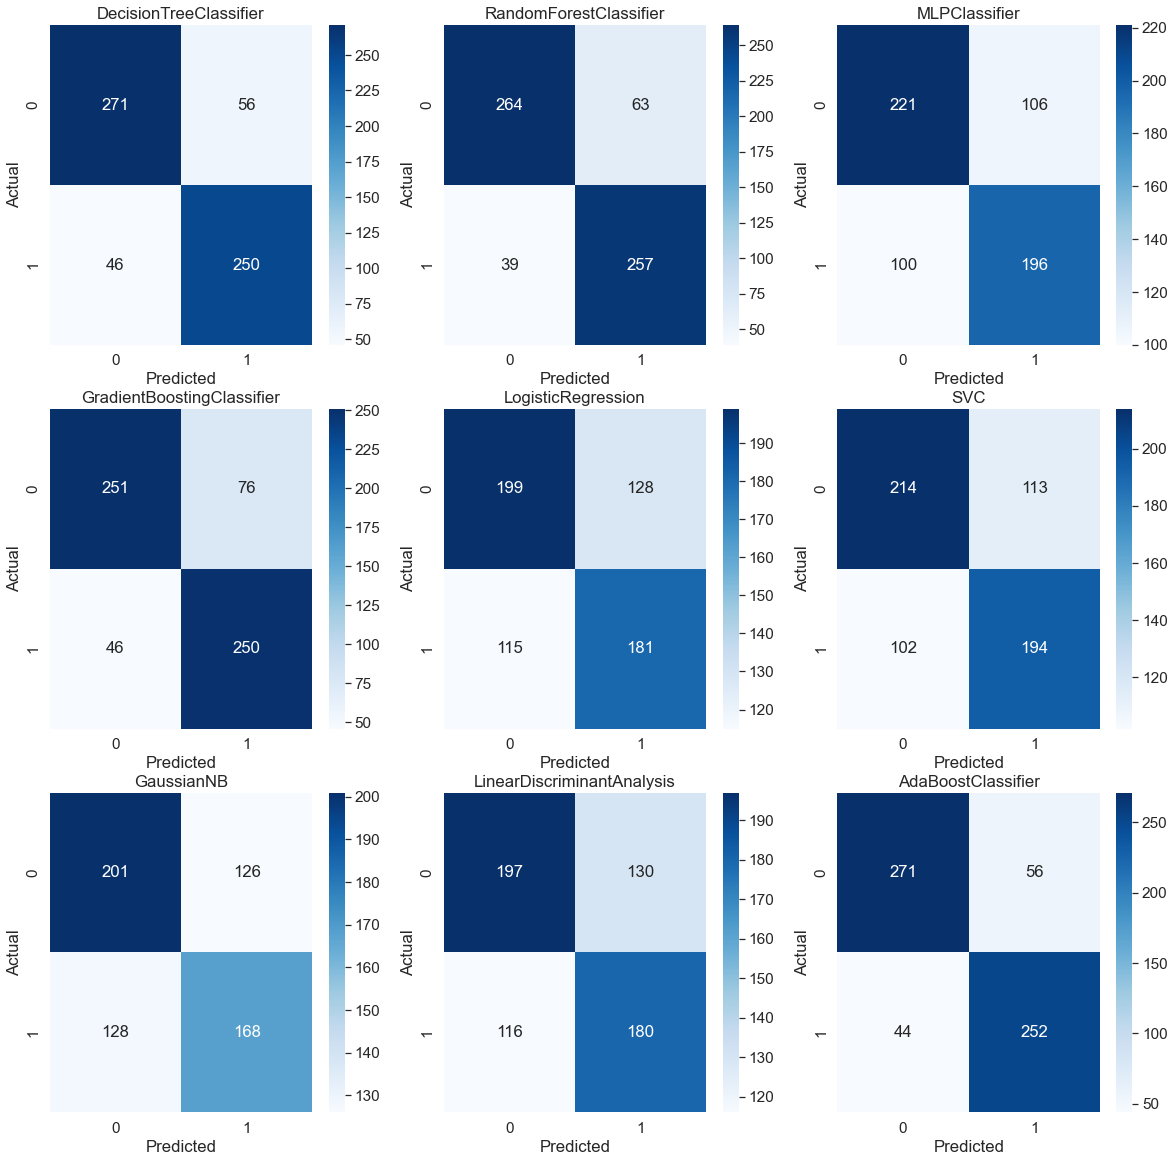

In [48]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [49]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       327
           1       0.82      0.84      0.83       296

    accuracy                           0.84       623
   macro avg       0.84      0.84      0.84       623
weighted avg       0.84      0.84      0.84       623

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       327
           1       0.80      0.87      0.83       296

    accuracy                           0.84       623
   macro avg       0.84      0.84      0.84       623
weighted avg       0.84      0.84      0.84       623

MLPClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       327
           1       0.65      0.66      0.66       296

    accuracy                           0.67       623

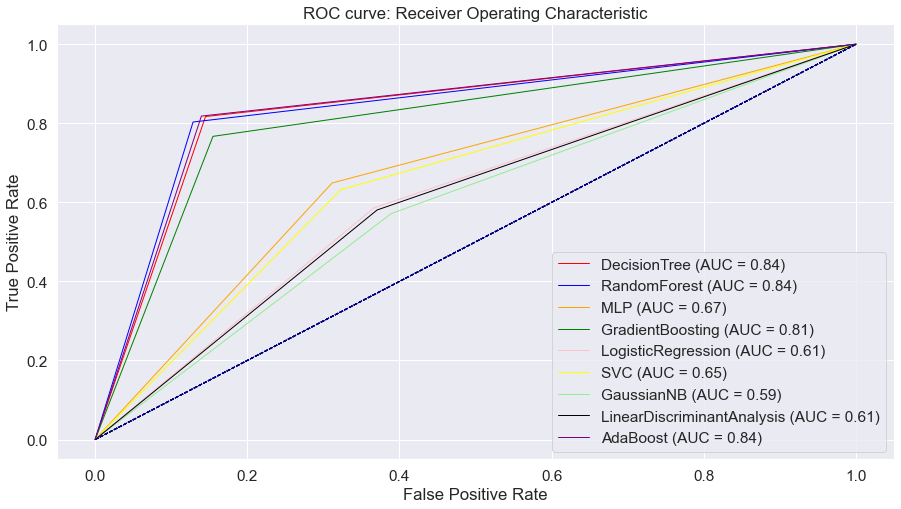

In [50]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [ ]:
cv_acc

[0.7232432432432432,
 0.742126126126126,
 0.621117117117117,
 0.715135135135135,
 0.6076396396396395,
 0.6506306306306305,
 0.5915315315315315,
 0.6022342342342342,
 0.7285765765765766]

In [51]:
# Search grid for optimal parameters


DT_param = {"max_depth": [2,3,8,10],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "criterion": ["gini"]}

RF_param = {"max_depth": [None],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100,300],
            "criterion": ["gini"]}

MLP_param = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive']}

GB_param = {'loss' : ["deviance"],
            'n_estimators' : [100,200,300],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [4, 8],
            'min_samples_leaf': [100,150],
            'max_features': [0.3, 0.1]}

#using 4 n_jobs for faster processing
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
MLPgs = GridSearchCV(MLPClassifier(), param_grid=MLP_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
GBgs = GridSearchCV(GradientBoostingClassifier(), param_grid=GB_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [DTgs, RFgs, MLPgs, GBgs]

gs_model = []
score = []

for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [52]:
# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[0], 3), round(cv_acc[1], 3), round(cv_acc[2], 3), round(cv_acc[3], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3), round(score[2], 3), round(score[3], 3))

score without GridSearchCV:  0.865 0.86 0.672 0.821
score with GridSearchCV:  0.847 0.866 0.75 0.84


Text(0.5, 1.0, 'Correlation between models')

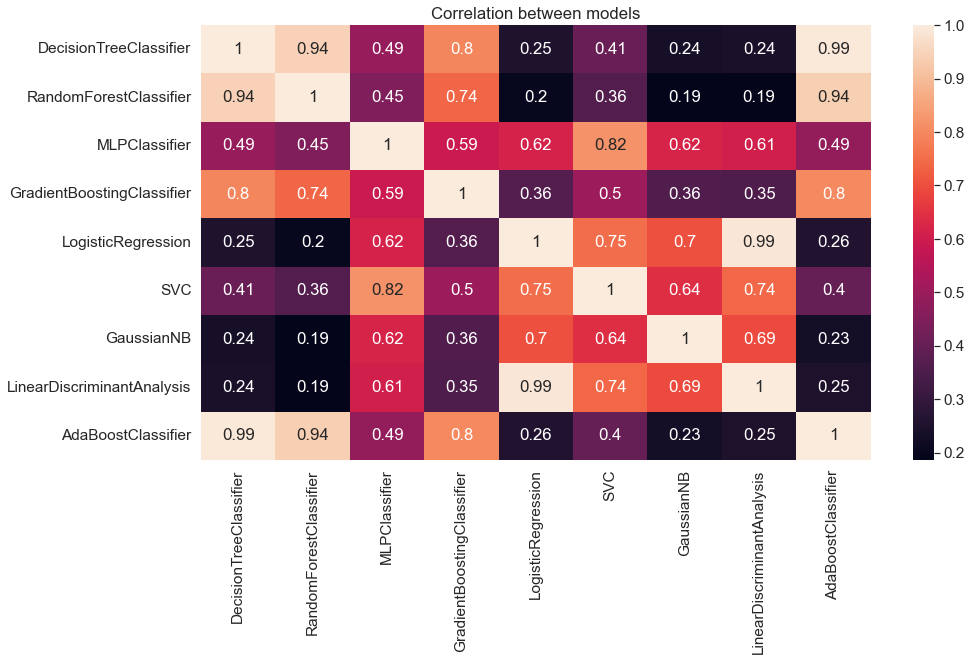

In [53]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop("squad_x_play_in_the_match", axis=1).corr(),annot=True)
plt.title("Correlation between models")

In [54]:
# Do model ensembling
best_model = VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1]),
('mpl', gs_model[2]), ('gb',gs_model[3])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))

0.8346709470304976


In [55]:
# Load the test data
d2 = pd.read_csv("./ETL_Mat/stats_match.csv")

team_play_in_the_match = d2[['match_name','substitutions']]
team_play_in_the_match = team_play_in_the_match.rename(columns={"substitutions": "squad_x_play_in_the_match"})
team_play_in_the_match['squad_x_play_in_the_match'] = 0
team_play_in_the_match.loc[team_play_in_the_match["match_name"].str.contains(squad_to_classify, regex=False), "squad_x_play_in_the_match"] = 1
d2 = d2.merge(team_play_in_the_match, on="match_name", how="left")
d2['score'] = d2['home_team_score'] - d2['away_team_score']
d2 = d2.drop(['home_team_name','home_team_id','home_team_code','away_team_name','away_team_id','away_team_code','home_team_score','away_team_score','home_team_score_margin','away_team_score_margin','home_team_score_penalties','away_team_score_penalties','home_team_win','away_team_win'], axis=1)

Match_Id = d2['match_name'] #save this variable for correct format of the submision

# Drop values
d2 = d2.drop(['match_name'], axis=1)

# Dealing with null values, for numerical:
for col in d2.columns:
    if d2[col].dtype != object:
        d2[col]=d2[col].fillna(df_match_stats[col].mean())

# Create dummies - for better model outcomes (also deals with nulls in categorical)
d2 = pd.get_dummies(d2)

# Data Normalization

scaled_d2 = scaler.transform(d2[["score",'yellow_card','red_card','substitutions']])

d2[["score",'yellow_card','red_card','substitutions']] = scaled_d2

# Drop values to avoid multicolinearity
d2 = d2.drop(['substitutions','red_card'], axis=1)


In [56]:
#train the model on the whole dataset and produce results:
survived_pred = pd.Series(best_model.predict(d2), name='squad_x_play_in_the_match')

In [57]:
survived_pred.value_counts()

0    1453
1     337
Name: squad_x_play_in_the_match, dtype: int64

In [58]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

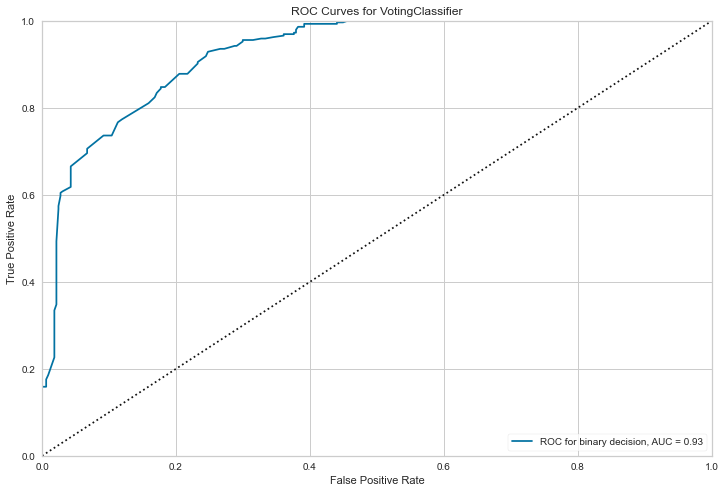

<AxesSubplot:title={'center':'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [59]:
# Instantiate the visualizer with the classification model
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=["squad_x_not_play_in_the_match", "squad_x_play_in_the_match"], micro=False, macro=False, binary=True)
visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

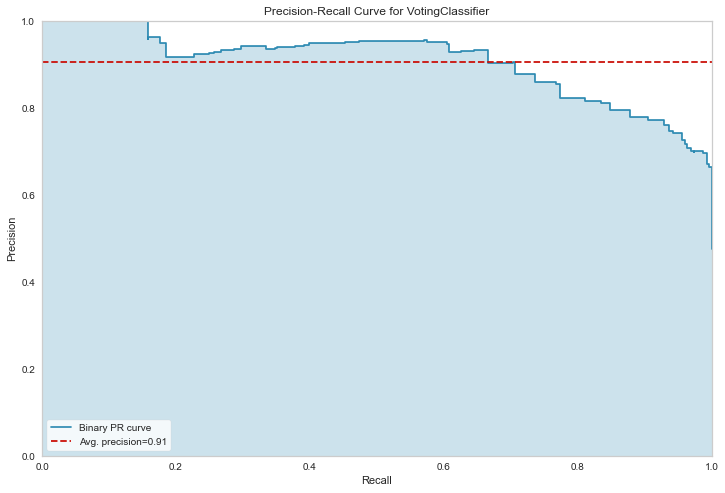

<AxesSubplot:title={'center':'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [60]:
plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

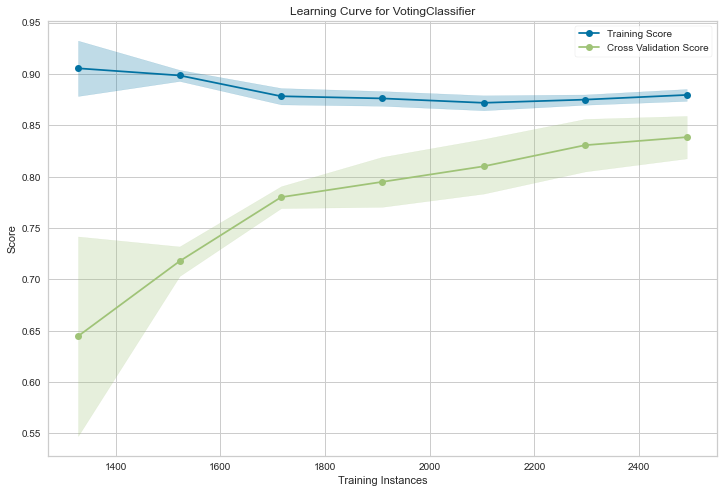

<AxesSubplot:title={'center':'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [61]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure